### Parse predictions for panproteins from DeepTMHMM, SignalP, and PSORTb

In [1]:
import pandas as pd
import pathlib

from Bio import SeqIO
from pyteomics import mass, parser, electrochem
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
signalp_out_folder = "signalP6/signalP_out/"
psortb_out_folder = "psortb/psortb_out/"
deeptmhmm_out_folder = "deepTMHMM_Predictions/"

In [3]:
# functions for parsing localisation prediction files

def parse_3line_file(file_path):
    protein_class_dict = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i in range(len(lines)):
            if lines[i].startswith(">"):
                # Extract the protein ID and class from the line
                line_parts = lines[i].strip().split(' | ')
                protein_id = line_parts[0].replace(">","")
                protein_class = line_parts[1]
                protein_class_dict[protein_id] = protein_class

    return protein_class_dict

def parse_gramneg_file(file_path):
    protein_localization_dict = {}
    current_protein_id = None
    final_prediction_flag = False

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Check for the SeqID line to extract the protein ID
            if line.startswith("SeqID:"):
                current_protein_id = line.split(" ")[1]
            # Check for the Final Prediction line to extract the localization
            elif line.strip().startswith("Final Prediction:"):
                final_prediction_flag = True
            elif final_prediction_flag:
                # The next line after "Final Prediction:" contains the localization
                localization = line.strip().split(" ")[0]
                if current_protein_id:
                    protein_localization_dict[current_protein_id] = localization
                final_prediction_flag = False  # Reset the flag after reading the localization

    return protein_localization_dict

In [4]:
def update_relationship_phrase(row, biosequence_to_relationship_phrase):
    if row["relationship_phrase"] == "identical":
        # return the relationship phrase of the protein it is identical to (=> the reference biosequence)
        identical_to = row["reference_biosequence"]
        return biosequence_to_relationship_phrase[identical_to]
    return row["relationship_phrase"]

# read in evidence levels from PA
folder = "/home/caro/EcoliPeptideAtlas/data/atlas_data/per_evidence_level"
files = Path(folder).glob("*.tsv")

IDs = {}

for file in files:
    name = file.name
    name = name.replace(".tsv", "").replace("PA2_", "")
    IDs[name] = pd.read_table(file)
    # filter out phages
    IDs[name] = IDs[name][~IDs[name]["biosequence_name"].str.contains("PHAGE_sp")]

    # update relationship phrase for proteins that are identical to an indistinguishable protein, not an identical one
    biosequence_to_relationship_phrase = {row["biosequence_name"]: row["relationship_phrase"] for index, row in IDs[name].iterrows()}
    IDs[name]["relationship_phrase"] = IDs[name].apply(lambda row: update_relationship_phrase(row, biosequence_to_relationship_phrase), axis=1)


# combine uncertain tiers into one
IDs["uncertain"] = pd.concat([IDs["weak"], IDs["insufficient_evidence"], IDs["subsumed"], IDs["indistinguishable_representative"]])
del IDs["insufficient_evidence"]
del IDs["subsumed"]
del IDs["indistinguishable_representative"]

# combine canonical and noncore canonical
IDs["canonical"] = pd.concat([IDs["canonical"], IDs["noncore_canonical"]])

# remove indistinguishables from canonical and add them to own tier
IDs["indistinguishable_from_canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] == "indistinguishable"]
IDs["canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] != "indistinguishable"]

# remove indistinguishables from uncertain and add them to uncertain tier
IDs["uncertain"] = pd.concat([IDs["uncertain"], IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] == "indistinguishable"]])
IDs["marginally_distinguished"] = IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] != "indistinguishable"]

del IDs["all_tiers"]
del IDs["noncore_canonical"]

biosequence_to_evidence_level = {}
for key in IDs:
    for index, row in IDs[key].iterrows():
        biosequence_to_evidence_level[row["biosequence_name"]] = key

# read in fasta
fasta = SeqIO.parse("/home/caro/EcoliPeptideAtlas/data/reference_proteomes/search_reference_proteomes/Ecoli_merged_nodup_contam_phage_2024-05_cleanacc_targetdecoy.fasta", "fasta")
# remove decoys
fasta = [record for record in fasta if "DECOY" not in record.id]
# create a dictionary with the protein sequence
protein_sequence_dict = {record.description: str(record.seq) for record in fasta}


In [5]:
# functions for calculating additional properties

def count_detectable_tryptic_peptides(sequence):
    sequence = sequence.replace("X", "")
    tryptic_peptides = parser.cleave(sequence, parser.expasy_rules["trypsin"], missed_cleavages=2)
    detectable_peptides = [peptide for peptide in tryptic_peptides if 6 <= len(peptide) <= 30 and 600 <= mass.calculate_mass(sequence=peptide) <= 4000]
    return len(detectable_peptides)

def calculate_isoelectric_point(sequence):
    sequence = sequence.replace("X", "")
    return electrochem.pI(sequence)

def calculate_gravy(sequence):
    sequence = sequence.replace("X", "")
    sequence = sequence.replace("U", "")
    return electrochem.gravy(sequence)

def get_evidence_level(biosequence_name):
    if "|" in biosequence_name:
        biosequence_name = biosequence_name.split("|")[1]
    try:
        return biosequence_to_evidence_level[biosequence_name]
    except KeyError:
        return "not observed"

def get_protein_sequence(accession):

    if "|" in accession:
        accession = accession.split("|")[1]

    for protein, sequence in protein_sequence_dict.items():
        if accession in protein:
            return sequence

    print(f"No protein sequence found for {accession}")
    return

In [6]:
def parse_clstr_file(filename):
    cluster_dict = {}
    current_cluster = None  # Variable to keep track of the current cluster being processed

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('>Cluster'):
                current_cluster = line.strip().split(' ')[1]  # Extract the cluster number
            else:
                if "sp|P0DPN7|YMDG_ECOLI" in line:
                    print(line)
                # Extract the protein ID from the line
                if ">ST" in line:
                    # e.g. >ST73_ECFI4_00021... at 100.00%
                    protein_id = "_".join(line.split('_')[1:3]).split('...')[0]
                elif "|" in line:
                    # e.g. >APEC_sp|A1A7A0|RSMA_ECOK1_00001... at 0.000
                    # or >K12_sp|P0CE51|INSH3_ECOLI
                    # remove part before first _
                    protein_id = line.split('_', 1)[1].split("...")[0]
                else:
                    # e.g. >ATCC25922_UPI00001363DE... at 0.000
                    protein_id = line.split('_')[1].split('...')[0]

                if "sp|P0DPN7|YMDG_ECOLI" in line:
                    print(protein_id)

                # set the strain to 1 in df
                cluster_dict[protein_id] = current_cluster

    return cluster_dict

### 1. Parse DeepTMHMM

In [7]:
canonical = IDs["canonical"]
canonical[canonical["represented_by_biosequence_id"] == "P0A9E0"]

biosequence_name biosequence_accession biosequence_gene_name is_covering  \
3849           P0A9E0                P0A9E0                  araC           C   
3856       A0A140NBX6            A0A140NBX6                   NaN         NaN   
3857     ECFI10_00066          ECFI10_00066                   NaN         NaN   
3858     ECFI19_00064          ECFI19_00064                   NaN         NaN   
3859    UPI0000030D3B         UPI0000030D3B                   NaN         NaN   

      pct_coverage presence_level  probability  confidence  n_observations  \
3849           NaN      canonical          1.0         0.0            60.0   
3856         37.67            NaN          NaN         NaN             NaN   
3857         37.67            NaN          NaN         NaN             NaN   
3858         37.67            NaN          NaN         NaN             NaN   
3859         37.67            NaN          NaN         NaN             NaN   

      norm_PSMs_per_100K  ...  relationship_phrase  reference_biosequence  \
3849                 NaN  ...                  NaN                    NaN   
3856                 NaN  ...                  NaN                 P0A9E0   
3857                 NaN  ...                  NaN                 P0A9E0   
3858                 NaN  ...                  NaN                 P0A9E0   
3859                 NaN  ...                  NaN                 P0A9E0   

      represented_by_biosequence_id  group_number  seq_unique_prots_in_group  \
3849                         P0A9E0          1563                          6   
3856                         P0A9E0          1563                          6   
3857                         P0A9E0          1563                          6   
3858                         P0A9E0          1563                          6   
3859                         P0A9E0          1563                          6   

      protein_group_seq_align_link  is_keratin is_immunoglobulin  \
3849                           NaN         NaN               NaN   
3856                           NaN         NaN               NaN   
3857                           NaN         NaN               NaN   
3858                           NaN         NaN               NaN   
3859                           NaN         NaN               NaN   

                                biosequence_description organism_full_name  
3849  strain/isolate=K-12 UPSP ARAC_ECOLI Arabinose ...   Escherichia coli  
3856  strain/isolate=BL21 UPTR A0A140NBX6_ECOBD Tran...   Escherichia coli  
3857  strain/isolate=ST93 Arabinose operon transcrip...   Escherichia coli  
3858  strain/isolate=ST1421 Arabinose operon transcr...   Escherichia coli  
3859  strain/isolate=DH5,K-12_MC4100,K-12_W3110,BW25...   Escherichia coli  

[5 rows x 27 columns]

In [8]:
deeptmhmm_results = pathlib.Path(deeptmhmm_out_folder).rglob("*.3line")
deeptmhmm_df = pd.DataFrame()
for file in deeptmhmm_results:
    file_path = str(file)
    strain = file_path.split("/")[1]
    protein_class_dict = parse_3line_file(file_path)

    # Create a DataFrame from the dictionary
    protein_class_df = pd.DataFrame(protein_class_dict.items(), columns=["Protein", "DeepTMHMM_Prediction"])
    protein_class_df["Strain"] = strain
    deeptmhmm_df = pd.concat([deeptmhmm_df, protein_class_df])

deeptmhmm_df

Protein DeepTMHMM_Prediction  \
0             ECFI10_00002                 GLOB   
1             ECFI10_00003                 GLOB   
2             ECFI10_00004                 GLOB   
3             ECFI10_00005                   SP   
4             ECFI10_00006                 GLOB   
...                    ...                  ...   
4399  sp|Q7DFV3|YMGG_ECOLI                   SP   
4400  sp|Q7DFV4|YMDE_ECOLI                 GLOB   
4401  sp|Q9XB42|YKFH_ECOLI                 GLOB   
4402  sp|Q9Z3A0|YJGW_ECOLI                 GLOB   
4403  sp|V9HVX0|YPAA_ECOLI                 GLOB   

                               Strain  
0                            WGS_ST93  
1                            WGS_ST93  
2                            WGS_ST93  
3                            WGS_ST93  
4                            WGS_ST93  
...                               ...  
4399  uniprot_UP000000625_08_2_24_K12  
4400  uniprot_UP000000625_08_2_24_K12  
4401  uniprot_UP000000625_08_2_24_K12  
4402  uniprot_UP000000625_08_2_24_K12  
4403  uniprot_UP000000625_08_2_24_K12  

[69089 rows x 3 columns]

### 2. parse PSORTb

In [9]:
psortb_results = pathlib.Path(psortb_out_folder).rglob("*gramneg.txt")
psortb_df = pd.DataFrame()
for file in psortb_results:
    file_path = str(file)
    strain = file_path.split("/")[2]
    protein_localization_dict = parse_gramneg_file(file_path)

    # Create a DataFrame from the dictionary
    protein_localization_df = pd.DataFrame(protein_localization_dict.items(), columns=["Protein", "PSORTb_Prediction"])
    protein_localization_df["Strain"] = strain
    psortb_df = pd.concat([psortb_df, protein_localization_df])

psortb_df

Protein PSORTb_Prediction                           Strain
0             ECFI10_00002       Cytoplasmic                         WGS_ST93
1             ECFI10_00003       Cytoplasmic                         WGS_ST93
2             ECFI10_00004       Cytoplasmic                         WGS_ST93
3             ECFI10_00005           Unknown                         WGS_ST93
4             ECFI10_00006       Cytoplasmic                         WGS_ST93
...                    ...               ...                              ...
4399  sp|Q7DFV3|YMGG_ECOLI           Unknown  uniprot_UP000000625_08_2_24_K12
4400  sp|Q7DFV4|YMDE_ECOLI           Unknown  uniprot_UP000000625_08_2_24_K12
4401  sp|Q9XB42|YKFH_ECOLI           Unknown  uniprot_UP000000625_08_2_24_K12
4402  sp|Q9Z3A0|YJGW_ECOLI           Unknown  uniprot_UP000000625_08_2_24_K12
4403  sp|V9HVX0|YPAA_ECOLI           Unknown  uniprot_UP000000625_08_2_24_K12

[69089 rows x 3 columns]

### 3. Parse SignalP

In [10]:
signalp_results = pathlib.Path(signalp_out_folder).rglob("prediction_results.txt")
signalp_df = pd.DataFrame()
for file in signalp_results:
    file_path = str(file)
    strain = file_path.split("/")[2]

    protein_localization_df = pd.read_table(file_path, usecols=["# ID", "Prediction"], skiprows=1)
    protein_localization_df.columns =  ["Protein", "SignalP_Prediction"]
    protein_localization_df["Strain"] = strain
    protein_localization_df["Protein"] = protein_localization_df["Protein"].str.split(" ").str[0]
    signalp_df = pd.concat([signalp_df, protein_localization_df])

signalp_df

Protein SignalP_Prediction                           Strain
0             ECFI10_00002              OTHER                         WGS_ST93
1             ECFI10_00003              OTHER                         WGS_ST93
2             ECFI10_00004              OTHER                         WGS_ST93
3             ECFI10_00005                 SP                         WGS_ST93
4             ECFI10_00006              OTHER                         WGS_ST93
...                    ...                ...                              ...
4399  sp|Q7DFV3|YMGG_ECOLI                 SP  uniprot_UP000000625_08_2_24_K12
4400  sp|Q7DFV4|YMDE_ECOLI              OTHER  uniprot_UP000000625_08_2_24_K12
4401  sp|Q9XB42|YKFH_ECOLI              OTHER  uniprot_UP000000625_08_2_24_K12
4402  sp|Q9Z3A0|YJGW_ECOLI              OTHER  uniprot_UP000000625_08_2_24_K12
4403  sp|V9HVX0|YPAA_ECOLI              OTHER  uniprot_UP000000625_08_2_24_K12

[69089 rows x 3 columns]

In [11]:
# check if every tool gave a prediction for every protein
signalp_counts = signalp_df["Strain"].value_counts().reset_index().rename(columns={"count": "count_signalp"})
psortb_counts = psortb_df["Strain"].value_counts().reset_index().rename(columns={"count": "psortb_count"})
deeptmhmm_counts = deeptmhmm_df["Strain"].value_counts().reset_index().rename(columns={"count": "deeptmhmm_count"})

count_table = pd.merge(signalp_counts, psortb_counts).merge(deeptmhmm_counts)
count_table


Strain  count_signalp  psortb_count  \
0    uniprot_UP000014099_23-02-23_ATCC25922           4901          4901   
1   uniprot_UP000008216_08_05_24_O1_K1_APEC           4870          4870   
2        uniprot_UP000005190_23-02-23_NC101           4728          4728   
3       uniprot_UP000869295_13-03-23_AB1157           4627          4627   
4       uniprot_UP000008205_08-05-24_O127H6           4594          4594   
5      uniprot_UP000036496_02-11-23_NCM3722           4504          4504   
6           uniprot_UP000000625_08_2_24_K12           4404          4404   
7        uniprot_UP000868987_02-11-23_W3110           4324          4324   
8          uniprot_UP001065293_07-11-23_DH5           4223          4223   
9         uniprot_UP000002032_07-05-24_BL21           4156          4156   
10     uniprot_UP000029103_23-02-23_BW25113           4095          4095   
11      uniprot_UP000001478_02-11-23_MC4100           4042          4042   
12                               WGS_ST1421           3995          3995   
13                                 WGS_ST93           3971          3971   
14                                WGS_ST131           3939          3939   
15                                 WGS_ST73           3716          3716   

    deeptmhmm_count  
0              4901  
1              4870  
2              4728  
3              4627  
4              4594  
5              4504  
6              4404  
7              4324  
8              4223  
9              4156  
10             4095  
11             4042  
12             3995  
13             3971  
14             3939  
15             3716

In [12]:
# merge the predictions into one table
predictions = pd.merge(signalp_df, psortb_df, on=["Strain", "Protein"], how="outer").merge(deeptmhmm_df, on=["Strain", "Protein"], how="outer")
predictions["SignalP_Prediction"] = predictions["SignalP_Prediction"].str.replace("SP", "SP_SignalP")

predictions.to_csv("../../../../data/atlas_data/cellular_localization_predictions.csv", index=False)
predictions

Protein SignalP_Prediction                            Strain  \
0       ECFI20_00002              OTHER                         WGS_ST131   
1       ECFI20_00003              OTHER                         WGS_ST131   
2       ECFI20_00004              OTHER                         WGS_ST131   
3       ECFI20_00005              OTHER                         WGS_ST131   
4       ECFI20_00006              OTHER                         WGS_ST131   
...              ...                ...                               ...   
69084  UPI00221A6F50              OTHER  uniprot_UP001065293_07-11-23_DH5   
69085  UPI00221ADD8D              OTHER  uniprot_UP001065293_07-11-23_DH5   
69086  UPI00221B0152              OTHER  uniprot_UP001065293_07-11-23_DH5   
69087  UPI00221B252B              OTHER  uniprot_UP001065293_07-11-23_DH5   
69088  UPI00221CB801              OTHER  uniprot_UP001065293_07-11-23_DH5   

      PSORTb_Prediction DeepTMHMM_Prediction  
0               Unknown                 GLOB  
1           Cytoplasmic                 GLOB  
2           Cytoplasmic                 GLOB  
3               Unknown                 GLOB  
4           Cytoplasmic                 GLOB  
...                 ...                  ...  
69084       Cytoplasmic                 GLOB  
69085       Periplasmic                 GLOB  
69086       Cytoplasmic                 GLOB  
69087           Unknown                 GLOB  
69088     Extracellular                 GLOB  

[69089 rows x 5 columns]

In [13]:
# add protein length, protein weight in Dalton, number of tryptic peptides, and isoelectric point
predictions["protein_sequence"] = predictions["Protein"].apply(get_protein_sequence)

# same protein sequence -> same properties
predictions = predictions.drop_duplicates(subset=["protein_sequence"])

In [14]:
predictions["protein_length"] = predictions["protein_sequence"].str.len()
predictions["protein_weight"] = predictions["protein_sequence"].apply(lambda x: mass.calculate_mass(sequence=x.replace("X", "")))

/tmp/ipykernel_3991318/4130360276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["protein_length"] = predictions["protein_sequence"].str.len()
/tmp/ipykernel_3991318/4130360276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["protein_weight"] = predictions["protein_sequence"].apply(lambda x: mass.calculate_mass(sequence=x.replace("X", "")))


In [15]:
# add number of detectable tryptic peptides (6-30 amino acids, 600-4000 Da)
predictions["detectable_tryptic_peptides"] = predictions["protein_sequence"].apply(count_detectable_tryptic_peptides)
# add isoelectric point
predictions["isoelectric_point"] = predictions["protein_sequence"].apply(calculate_isoelectric_point)
# add gravy index
predictions["gravy"] = predictions["protein_sequence"].apply(calculate_gravy)
# add observation status from PeptideAtlas
predictions["evidence_level"] = predictions["Protein"].apply(lambda x: get_evidence_level(x))
predictions["observed"] = predictions["evidence_level"] != "not observed"

predictions

/tmp/ipykernel_3991318/3158019768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["detectable_tryptic_peptides"] = predictions["protein_sequence"].apply(count_detectable_tryptic_peptides)
/tmp/ipykernel_3991318/3158019768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["isoelectric_point"] = predictions["protein_sequence"].apply(calculate_isoelectric_point)
/tmp/ipykernel_3991318/3158019768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Protein SignalP_Prediction                            Strain  \
0       ECFI20_00002              OTHER                         WGS_ST131   
1       ECFI20_00003              OTHER                         WGS_ST131   
2       ECFI20_00004              OTHER                         WGS_ST131   
3       ECFI20_00005              OTHER                         WGS_ST131   
4       ECFI20_00006              OTHER                         WGS_ST131   
...              ...                ...                               ...   
69084  UPI00221A6F50              OTHER  uniprot_UP001065293_07-11-23_DH5   
69085  UPI00221ADD8D              OTHER  uniprot_UP001065293_07-11-23_DH5   
69086  UPI00221B0152              OTHER  uniprot_UP001065293_07-11-23_DH5   
69087  UPI00221B252B              OTHER  uniprot_UP001065293_07-11-23_DH5   
69088  UPI00221CB801              OTHER  uniprot_UP001065293_07-11-23_DH5   

      PSORTb_Prediction DeepTMHMM_Prediction  \
0               Unknown                 GLOB   
1           Cytoplasmic                 GLOB   
2           Cytoplasmic                 GLOB   
3               Unknown                 GLOB   
4           Cytoplasmic                 GLOB   
...                 ...                  ...   
69084       Cytoplasmic                 GLOB   
69085       Periplasmic                 GLOB   
69086       Cytoplasmic                 GLOB   
69087           Unknown                 GLOB   
69088     Extracellular                 GLOB   

                                        protein_sequence  protein_length  \
0      MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...             342   
1      MQEEFYLELKEGLLEPLAVTERLAIISVVGDGMRTLRGISAKFFAA...             219   
2      MKFSGILSGSLSYIFGKLDEGMSFSEATTLAREMGYTEPDPRDDLS...             148   
3      MIVKNGENALAFYSHYYQPLPLVLRGYGAGNDVTAAGVFADLLRTL...              52   
4      MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...             310   
...                                                  ...             ...   
69084  MLVSKKPMVLVILDGYGYREEQQDNAIFSAKTPVMDALWANRPHTL...             514   
69085  MVQKVGASAPAIDYHSQQMALPASTQKVITALAALIQLGPDFRFTT...             439   
69086  MAKEGYVNLLPVQHKRSRDPGDSAEMMQARRAFLDAGHYQPLRDAI...             241   
69087  MIDFSVFPPSIKEVIRTHDDEVADANFQKQMLISDATDFINSRQWQ...              94   
69088  MEAPVEPQSTQLAVSDAAAVTFPATVSAPPVTPAVVKSAFSTAQID...             584   

       protein_weight  detectable_tryptic_peptides  isoelectric_point  \
0        36699.840164                           58           6.401855   
1        24205.700662                           39           5.943848   
2        16360.301135                           32           4.351074   
3         5667.970455                            6           9.307129   
4        33559.844898                           42           5.137207   
...               ...                          ...                ...   
69084    56128.285122                           97           4.904785   
69085    47731.465639                           76           9.272949   
69086    27098.684242                           48           6.538574   
69087    10772.395234                           14           4.063965   
69088    65848.587083                          119           7.215332   

          gravy                    evidence_level  observed  
0      0.100000                         uncertain      True  
1      0.037443                         uncertain      True  
2     -0.281757                         uncertain      True  
3      0.288462                         uncertain      True  
4      0.027419                         uncertain      True  
...         ...                               ...       ...  
69084 -0.190272                         uncertain      True  
69085 -0.112984                         uncertain      True  
69086 -0.233610                         uncertain      True  
69087 -0.442553                         uncertain      True  
69088 -0.896918  indistinguishable_from

In [16]:
predictions["observed"].value_counts()

observed
True     21361
False     6445
Name: count, dtype: int64

## Count identified homology clusters per localisation

In [17]:
# step 1: read in cluster file at 70%, make dict from protein to cluster ID
filename = "/home/caro/EcoliPeptideAtlas/src/analysis/search_proteome/cd-hit/clusterings/cdhit_stains_prefixed_cdhit_c.70.fasta.clstr"
cluster_dict = parse_clstr_file(filename)

# step 2: add cluster ID to predictions
predictions["clusterID"] = predictions["Protein"].apply(lambda x: cluster_dict[x] if x in cluster_dict else -1)

# step 3: groupby cluster ID and aggregate localisation predictions and confidence
cluster_predictions = predictions.groupby("clusterID").agg({"SignalP_Prediction": pd.Series.mode, "PSORTb_Prediction": pd.Series.mode, "DeepTMHMM_Prediction": pd.Series.mode, "evidence_level": lambda x: set(x)})

# step 4: if there are multiple localisations, assign unknown
cluster_predictions["PSORTb_Prediction"] = cluster_predictions["PSORTb_Prediction"].apply(lambda x: "Unknown" if len(str(x)) > 20 else x)

# step 4: filter for clusters that have at least 1 canonical protein
cluster_predictions_canonical = cluster_predictions[cluster_predictions["evidence_level"].apply(lambda x: "canonical" in x)]

# step 4: count clusters per localisation
print("counts across canonically identified homology clusters:")

cluster_predictions_canonical["PSORTb_Prediction"].value_counts()

/tmp/ipykernel_3991318/464228607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["clusterID"] = predictions["Protein"].apply(lambda x: cluster_dict[x] if x in cluster_dict else -1)


counts across canonically identified homology clusters:


PSORTb_Prediction
Cytoplasmic            2078
Unknown                 959
CytoplasmicMembrane     712
Periplasmic             155
OuterMembrane           104
Extracellular            60
Name: count, dtype: int64

In [18]:
# how many clusters have been observed? e.g. at least one protein in the cluster has been observed
print("clusters at 70% similarity in total: ", len(cluster_predictions))
print("clusters not observed: ", len(cluster_predictions[cluster_predictions["evidence_level"] == {'not observed'}]))
print("clusters observed: ", len(cluster_predictions[cluster_predictions["evidence_level"] != {'not observed'}]))

clusters at 70% similarity in total:  8311
clusters not observed:  3276
clusters observed:  5035


In [19]:
print("counts across all homology clusters:")
cluster_predictions["PSORTb_Prediction"].value_counts()

counts across all homology clusters:


PSORTb_Prediction
Unknown                3224
Cytoplasmic            2958
CytoplasmicMembrane    1556
Periplasmic             235
OuterMembrane           183
Extracellular           155
Name: count, dtype: int64

## Explore properties of observed vs not observed proteoforms

In [20]:
# same sequence -> same properties
proteoform_predictions = predictions.drop_duplicates(subset=["protein_sequence"])

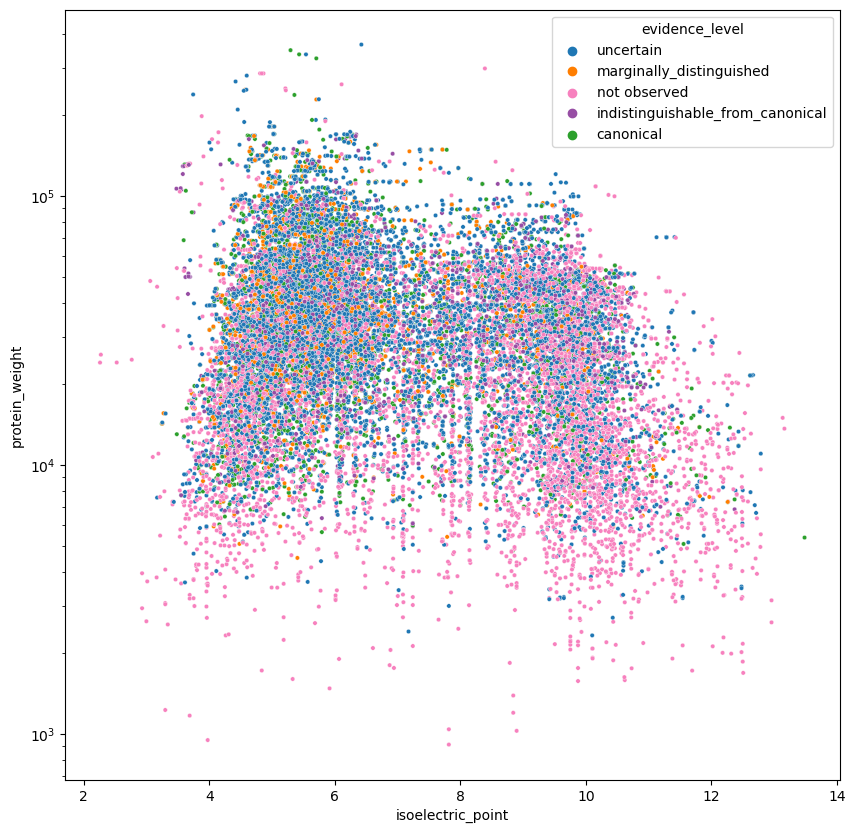

In [21]:
# plot pI vs molecular weight, color by evidence level, log scale on molecular weight
plt.figure(figsize=(10, 10))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="evidence_level", s=10,  palette = {"uncertain": "#1F77B4", "marginally_distinguished" : "#FF7E00", "not observed": "#F781BE", "indistinguishable_from_canonical": "#974EA4", "canonical": "#2CA02C"})
plt.yscale("log")

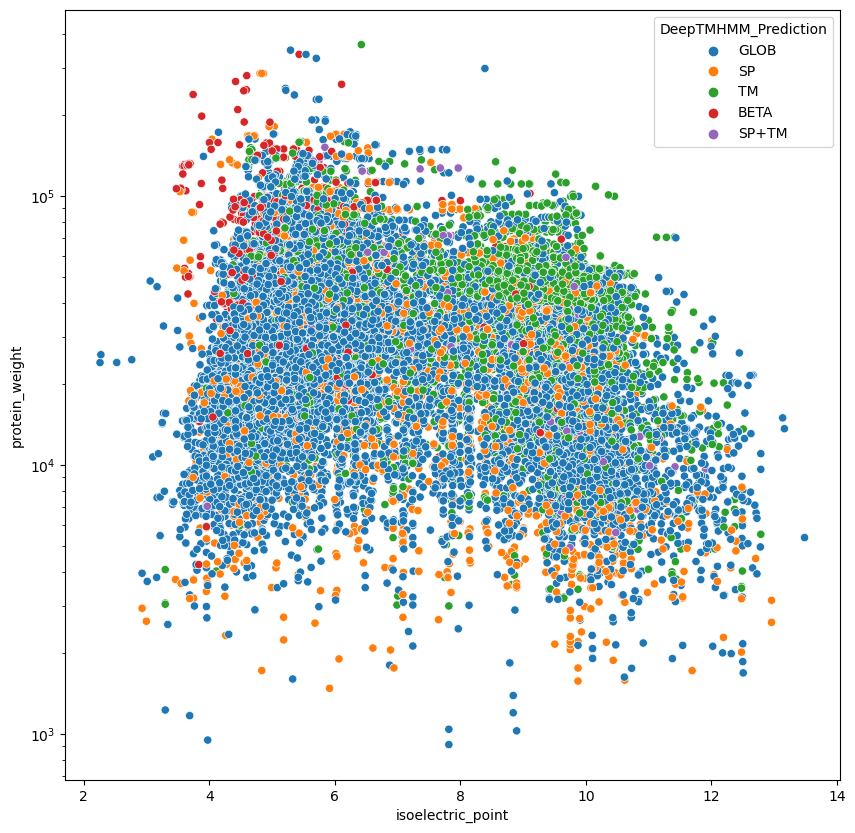

In [22]:
# plot pI vs molecular weight, color by localisation, log scale on molecular weight
plt.figure(figsize=(10, 10))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="DeepTMHMM_Prediction")
plt.yscale("log")

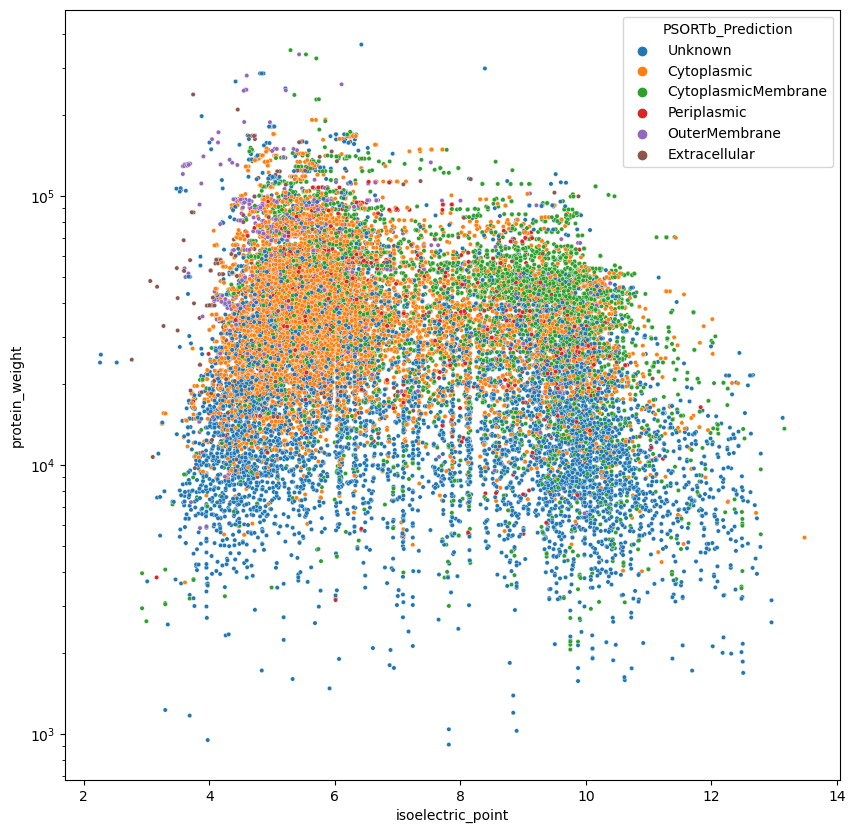

In [23]:
# plot pI vs molecular weight, color by localisation, log scale on molecular weight
plt.figure(figsize=(10, 10))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="PSORTb_Prediction", s=10)
plt.yscale("log")

(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 [Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

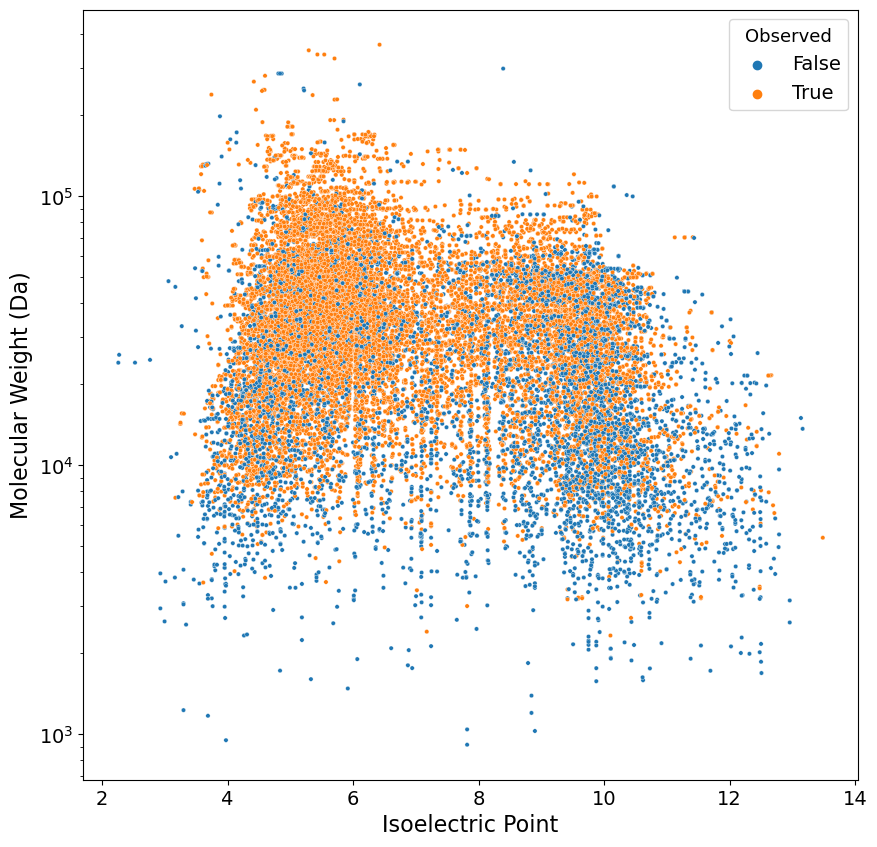

In [24]:
# plot pI vs molecular weight, color by localisation, log scale on molecular weight
plt.figure(figsize=(10, 10))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="observed", s=10)
plt.yscale("log")

# make labels bigger
plt.xlabel("Isoelectric Point", fontsize=16)
plt.ylabel("Molecular Weight (Da)", fontsize=16)

# make legend bigger
plt.legend(fontsize=14, title="Observed", title_fontsize='13', loc='upper right')

# make ticks bigger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/

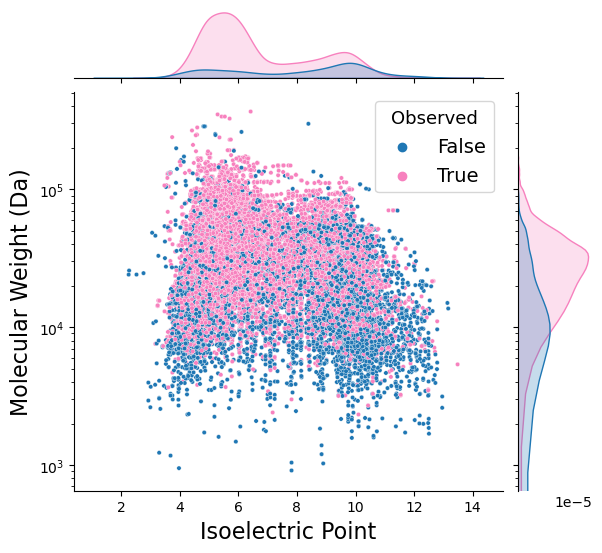

In [25]:
# plot the isoelectric point vs molecular weight, add marginal distributions, log scale on molecular weight
g = sns.jointplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="observed", kind="scatter", palette = {False: "#1F77B4", True : "#F781BE"}, s=10)
g.ax_joint.set_yscale('log')
# make the marginal distributions larger
plt.subplots_adjust(top=0.9)
plt.xlabel("Isoelectric Point", fontsize=16)
plt.ylabel("Molecular Weight (Da)", fontsize=16)
# make legend bigger
plt.legend(fontsize=14, title="Observed", title_fontsize='13', loc='upper right')


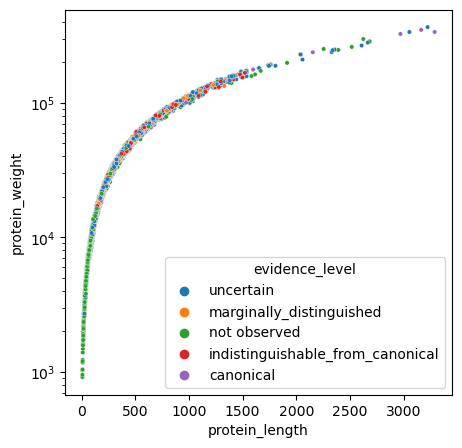

In [26]:
plt.figure(figsize=(5, 5))

sns.scatterplot(data=proteoform_predictions, x="protein_length", y="protein_weight", hue="evidence_level", s=10)
plt.yscale("log")

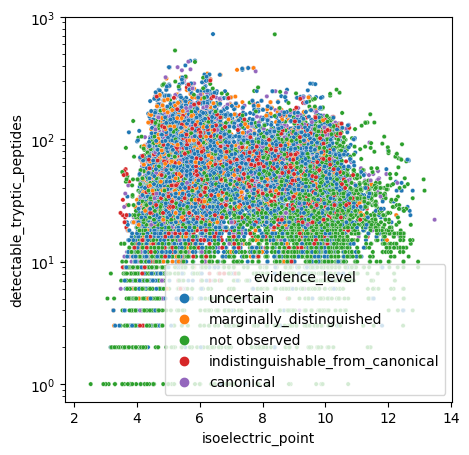

In [27]:
plt.figure(figsize=(5, 5))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="detectable_tryptic_peptides", hue="evidence_level", s=10)
plt.yscale("log")

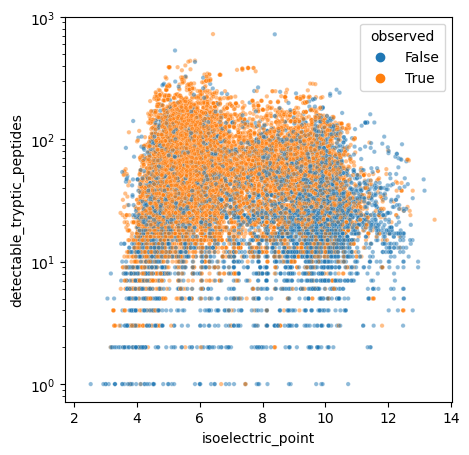

In [28]:
plt.figure(figsize=(5, 5))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="detectable_tryptic_peptides", hue="observed", s=10, alpha=0.5)
plt.yscale("log")

<Axes: xlabel='isoelectric_point', ylabel='gravy'>

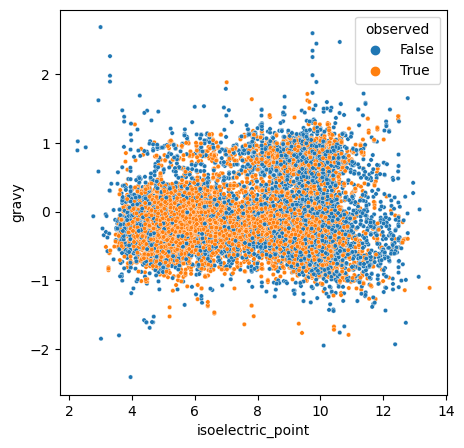

In [29]:
plt.figure(figsize=(5, 5))

sns.scatterplot(data=proteoform_predictions, x="isoelectric_point", y="gravy", hue="observed", s=10)
#plt.yscale("log")

<Axes: xlabel='detectable_tryptic_peptides', ylabel='gravy'>

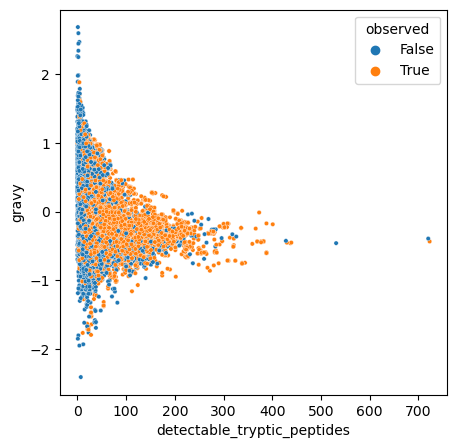

In [30]:
plt.figure(figsize=(5, 5))

sns.scatterplot(data=proteoform_predictions, x="detectable_tryptic_peptides", y="gravy", hue="observed", s=10)
#plt.yscale("log")

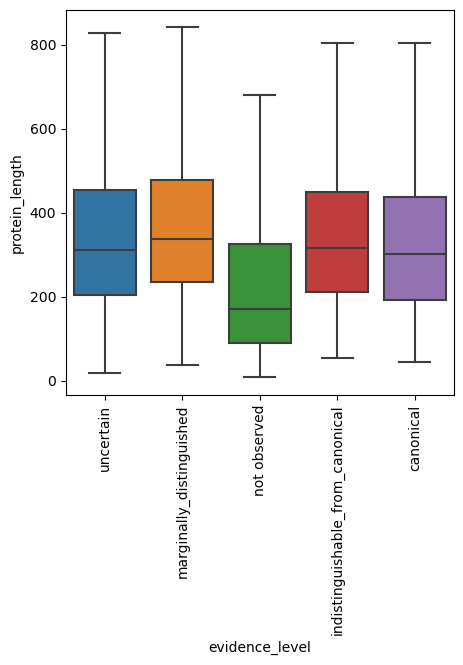

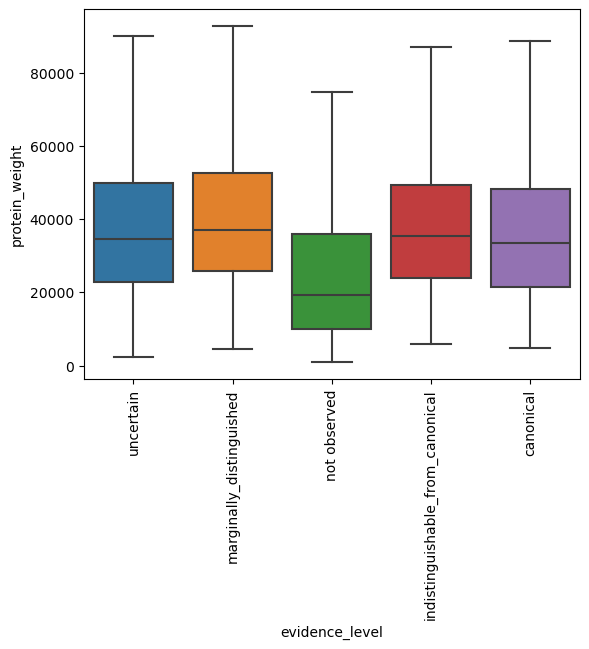

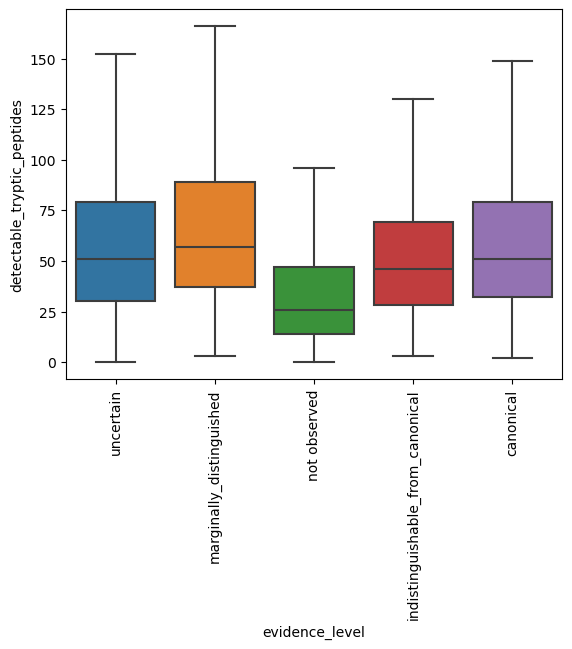

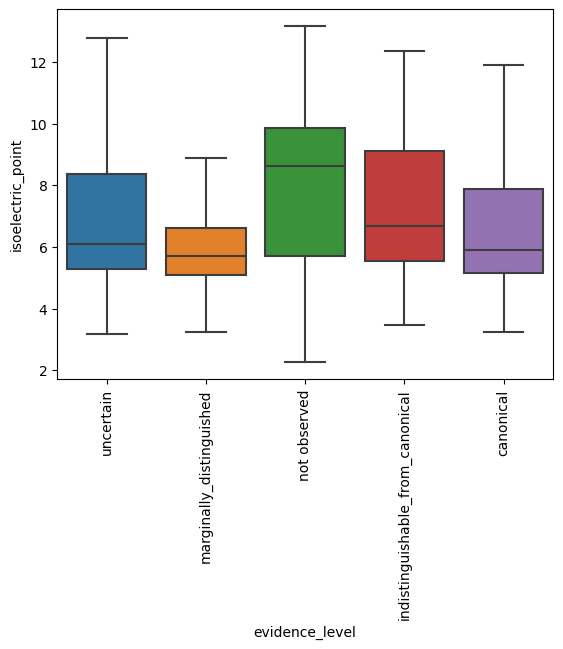

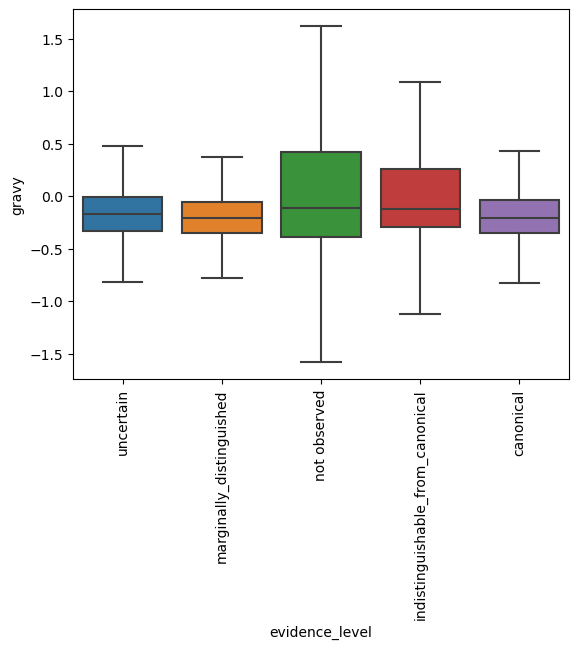

In [31]:
# turn each column into a boxplot, color by evidence level
plt.figure(figsize=(5, 5))

for column in ["protein_length", "protein_weight", "detectable_tryptic_peptides", "isoelectric_point", "gravy"]:
    sns.boxplot(data=proteoform_predictions, y=column, x="evidence_level", showfliers=False)
    # rotate x ticks
    plt.xticks(rotation=90)
    plt.show()


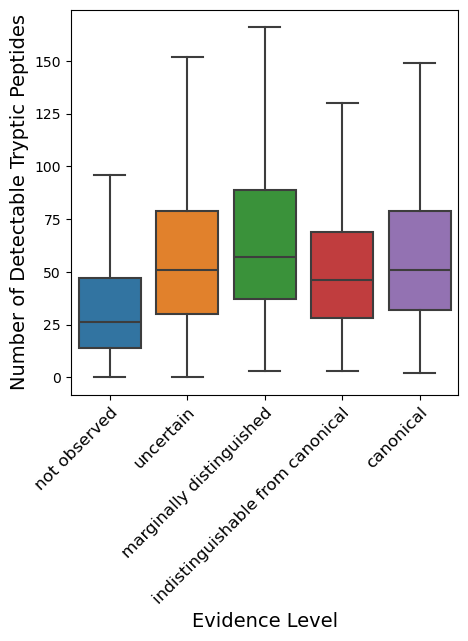

In [32]:
# color by evidence level
# fix order of columns

plt.figure(figsize=(5, 5))

# fix order of evidence levels
evidence_order = ["not observed", "uncertain", "marginally_distinguished", "indistinguishable_from_canonical", "canonical"]
sns.boxplot(data=proteoform_predictions, y="detectable_tryptic_peptides", x="evidence_level", showfliers=False, order=evidence_order)
# rotate x ticks
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
# replace _ with space in x ticks
plt.xticks(ticks=np.arange(len(evidence_order)), labels=[key.replace("_", " ") for key in evidence_order], fontsize=12)

plt.xlabel("Evidence Level", fontsize=14)
plt.ylabel("Number of Detectable Tryptic Peptides", fontsize=14)

plt.show()


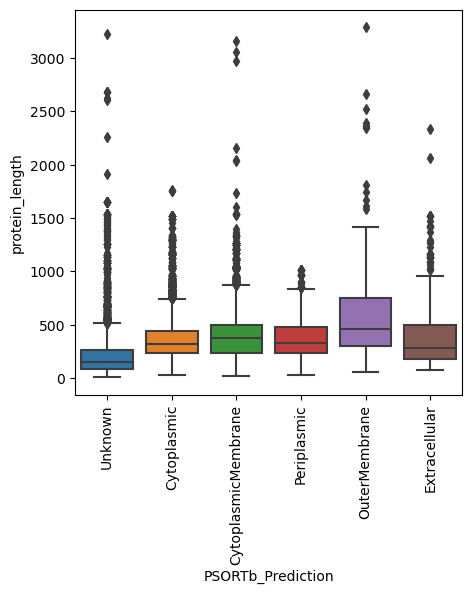

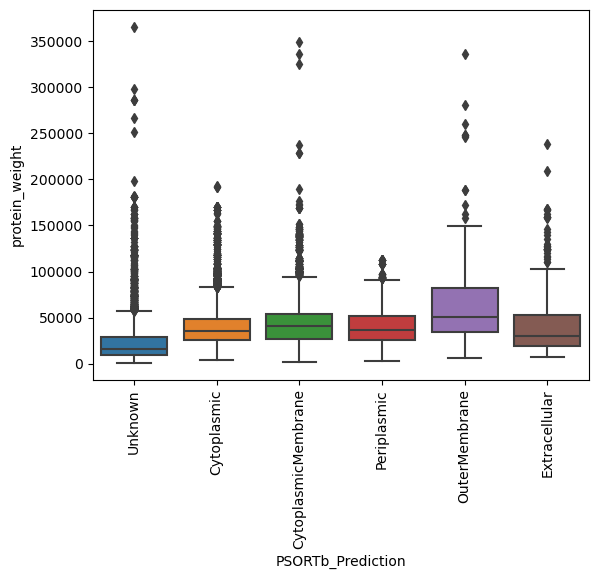

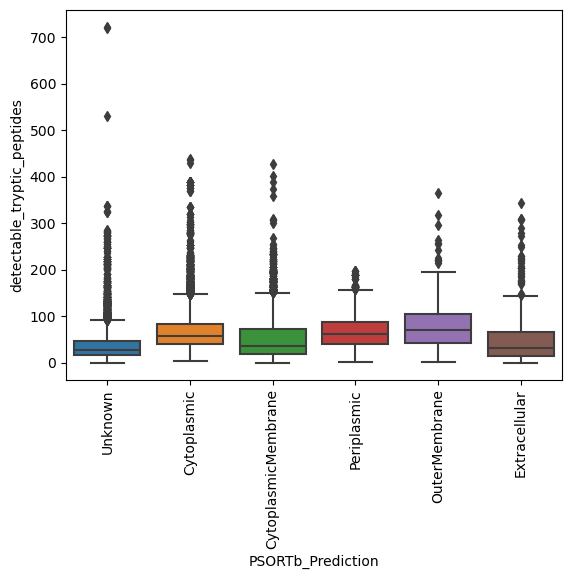

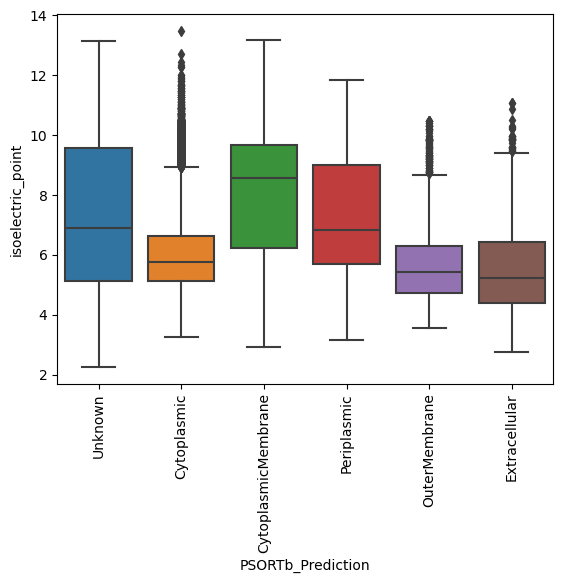

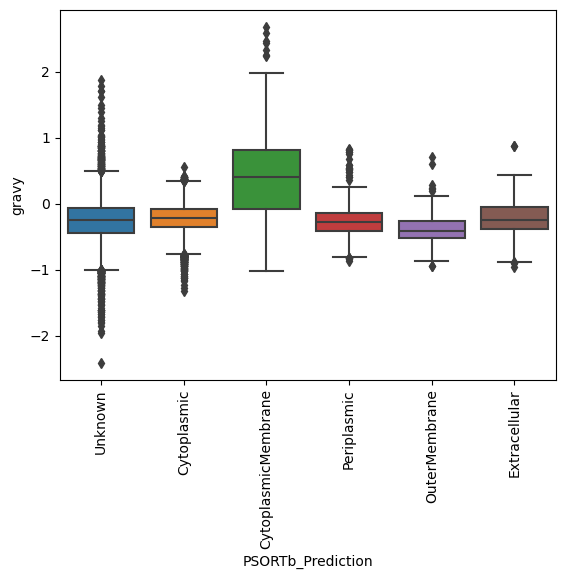

In [33]:
# turn each column into a boxplot, color by evidence level
plt.figure(figsize=(5, 5))

for column in ["protein_length", "protein_weight", "detectable_tryptic_peptides", "isoelectric_point", "gravy"]:
    sns.boxplot(data=proteoform_predictions, y=column, x="PSORTb_Prediction")
    # rotate x ticks
    plt.xticks(rotation=90)
    plt.show()


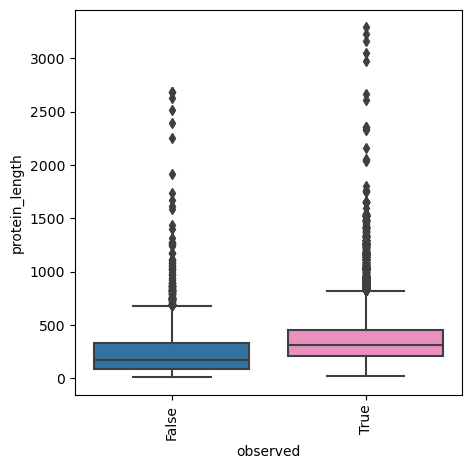

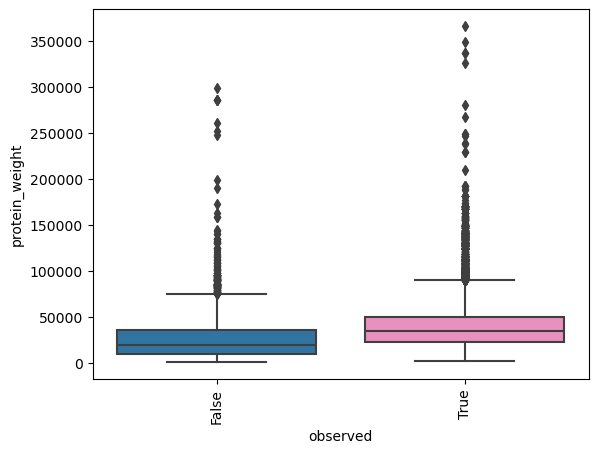

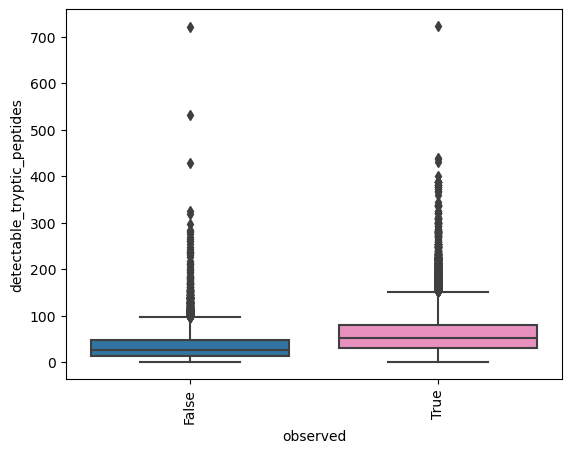

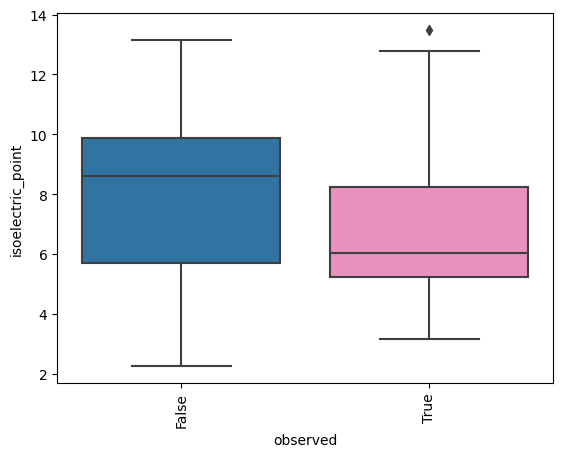

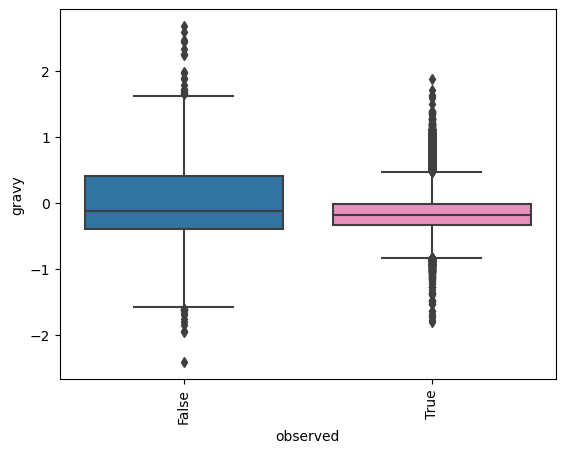

In [34]:
# turn each column into a boxplot, color by evidence level
plt.figure(figsize=(5, 5))


for column in ["protein_length", "protein_weight", "detectable_tryptic_peptides", "isoelectric_point", "gravy"]:
    # assign orange to not observed, blue to observed
    sns.boxplot(data=proteoform_predictions, y=column, x="observed", palette={True: "#F781BE", False: "#1F77B4"})

    # rotate x ticks
    plt.xticks(rotation=90)
    plt.show()


Text(0, 0.5, 'Proteoform count')

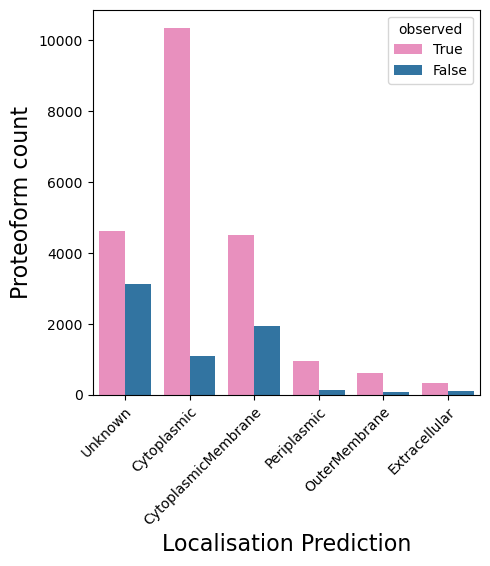

In [37]:
# bar chart per localisation: how many observed vs how many unobserved?
plt.figure(figsize=(5, 5))
sns.countplot(data=proteoform_predictions.astype({"observed": str}), x="PSORTb_Prediction", hue="observed", palette={"True": "#F781BE", "False": "#1F77B4"})
# rotate x ticks
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
# move x ticks to the middle of the bars

plt.xlabel("Localisation Prediction", fontsize=16)
plt.ylabel("Proteoform count", fontsize=16)



(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GLOB'),
  Text(1, 0, 'SP'),
  Text(2, 0, 'TM'),
  Text(3, 0, 'BETA'),
  Text(4, 0, 'SP+TM')])

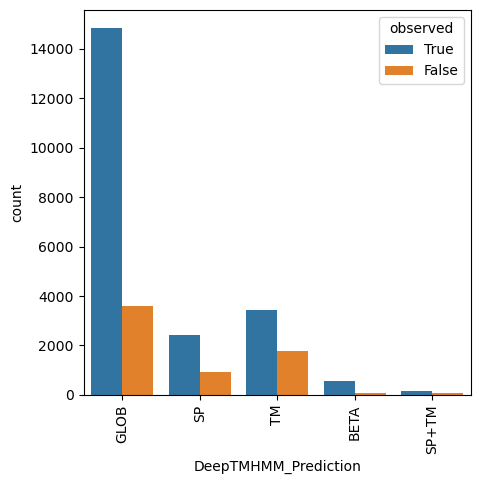

In [ ]:
# bar chart per localisation: how many observed vs how many unobserved?
plt.figure(figsize=(5, 5))
sns.countplot(data=proteoform_predictions.astype({"observed": str}), x="DeepTMHMM_Prediction", hue="observed")
# rotate x ticks
plt.xticks(rotation=90)

## Check differences between PSORTb, SignalP and DeepTMHMM

In [ ]:
K12 = predictions[predictions["Strain"] == "uniprot_UP000000625_08_2_24_K12"]

In [ ]:
K12

Protein SignalP_Prediction  \
15621       sp|A0A385XJ53|INSA9_ECOLI              OTHER   
15622       sp|A0A385XJE6|INH21_ECOLI              OTHER   
15623        sp|A0A385XJK5|YPAB_ECOLI              OTHER   
15624        sp|A0A385XJL2|YGDT_ECOLI              OTHER   
15625       sp|A0A385XJL4|INSB9_ECOLI              OTHER   
...                               ...                ...   
20020            sp|U3PVA8|IROK_ECOLI              OTHER   
20021            sp|V9HVX0|YPAA_ECOLI              OTHER   
20022  tr|A0A385XJN2|A0A385XJN2_ECOLI              OTHER   
20023  tr|A0A385XK32|A0A385XK32_ECOLI              OTHER   
20024  tr|A0A9F2H0S5|A0A9F2H0S5_ECOLI               LIPO   

                                Strain PSORTb_Prediction DeepTMHMM_Prediction  \
15621  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
15622  uniprot_UP000000625_08_2_24_K12       Cytoplasmic                 GLOB   
15623  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
15624  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
15625  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
...                                ...               ...                  ...   
20020  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
20021  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
20022  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
20023  uniprot_UP000000625_08_2_24_K12           Unknown                 GLOB   
20024  uniprot_UP000000625_08_2_24_K12           Unknown                   SP   

                                        protein_sequence  protein_length  \
15621  MASVSISCPSCSATDGVVRNGKSTAGHQRYLCSHCRKTWQLQFTYT...              91   
15622  MSHQLTFADSEFSSKRRQTRKEIFLSRMEQILPWQNMVEVIEPFYP...             326   
15623    MTLLQVHNFVDNSGRKKWLSRTLGQTRCPGKSMGREKFVKNNCSAIS              47   
15624   MLSTESWDNCEKPPLLFPFTALTCDETPVFSGSVLNLVAHSVDKYGIG              48   
15625  MPGNSPHYGRWPQHDFTSLKKLRPQSVTSRIQPGSDVIVCAEMDEQ...             167   
...                                                  ...             ...   
20020                              MKPALRDFIAIVQERLASVTA              21   
20021  MTIAERLRQEGHQIGWQEGKLEGLHEQAIKIALRMLEQGFDRDQVL...              61   
20022  MTTTGLRPRLNVRQRKDTGYLPHSSPFSLQFRPAILYSDGYLPLVP...              86   
20023  MHMVTYPCLTSRRFQLALIHRRVVDKRTSMHSRTASESTGARIHRP...              89   
20024          MKIRCFCIVLIVSGALLTEVNNNRSLSGDNLLVVNNLQSSK              41   

       protein_weight  detectable_tryptic_peptides  isoelectric_point  \
15621     9861.878602                           25          10.687988   
15622    37827.330267                           78           9.888184   
15623     5321.727088                           17          11.077637   
15624     5227.523237                            0           3.954590   
15625    19552.208264                           52          10.482910   
...               ...                          ...                ...   
20020     2328.298772                            5          10.100098   
20021     6876.494041                           15           4.973145   
20022     9910.074013                           18           9.901855   
20023    10578.366045                           34          11.494629   
20024     4474.386230                            4           9.033691   

          gravy            evidence_level  observed clusterID  
15621 -0.316484  marginally_distinguished      True         8  
15622 -0.584663                 uncertain      True         3  
15623 -0.646809              not observed     False      5362  
15624  0.154167              not observed     False      3839  
15625 -0.520958              not observed     False         2  
...         ...                       ...       ...       ...  
20020  0.495238                 uncertain      True      3547  
20021 -0.547541              not o

In [ ]:
import plotly.graph_objects as go
# Prepare the data for the Sankey diagram
source_target_pairs = []

# Create pairs for Prediction1 -> Prediction2
source_target_pairs.extend(zip(K12['DeepTMHMM_Prediction'], K12['SignalP_Prediction']))

# Create pairs for Prediction2 -> Prediction3
source_target_pairs.extend(zip(K12['SignalP_Prediction'], K12['PSORTb_Prediction']))

# Create a DataFrame from the pairs
pairs_df = pd.DataFrame(source_target_pairs, columns=['source', 'target'])

# Count the occurrences of each pair
pairs_df['value'] = 1
pairs_df = pairs_df.groupby(['source', 'target']).sum().reset_index()

# Create a list of unique labels
labels = list(pd.concat([pairs_df['source'], pairs_df['target']]).unique())

# Create a mapping from labels to indices
label_to_index = {label: i for i, label in enumerate(labels)}

# Map source and target labels to indices
pairs_df['source_index'] = pairs_df['source'].map(label_to_index)
pairs_df['target_index'] = pairs_df['target'].map(label_to_index)

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=pairs_df['source_index'],
        target=pairs_df['target_index'],
        value=pairs_df['value']
    )
)])

fig.update_layout(title_text="Sankey Diagram for Prediction Classes", font_size=10)

# make figure smaller
fig.update_layout(width=600, height=400)

#fig.show()

In [ ]:
import plotly.graph_objects as go
# Prepare the data for the Sankey diagram
source_target_pairs = []

# Create pairs for Prediction1 -> Prediction2
source_target_pairs.extend(zip(K12['DeepTMHMM_Prediction'], K12['PSORTb_Prediction']))

# Create a DataFrame from the pairs
pairs_df = pd.DataFrame(source_target_pairs, columns=['source', 'target'])

# Count the occurrences of each pair
pairs_df['value'] = 1
pairs_df = pairs_df.groupby(['source', 'target']).sum().reset_index()

# Create a list of unique labels
labels = list(pd.concat([pairs_df['source'], pairs_df['target']]).unique())

# Create a mapping from labels to indices
label_to_index = {label: i for i, label in enumerate(labels)}

# Map source and target labels to indices
pairs_df['source_index'] = pairs_df['source'].map(label_to_index)
pairs_df['target_index'] = pairs_df['target'].map(label_to_index)

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=pairs_df['source_index'],
        target=pairs_df['target_index'],
        value=pairs_df['value']
    )
)])

fig.update_layout(title_text="Sankey Diagram for Prediction Classes", font_size=10)

# make figure smaller
fig.update_layout(width=400, height=400)
#fig.show()

In [ ]:
K12["PSORTb_Prediction"].value_counts()

PSORTb_Prediction
Cytoplasmic            1955
CytoplasmicMembrane    1092
Unknown                1059
Periplasmic             161
OuterMembrane            89
Extracellular            48
Name: count, dtype: int64

In [ ]:
K12.groupby(["PSORTb_Prediction", "evidence_level"]).size()

PSORTb_Prediction    evidence_level          
Cytoplasmic          canonical                   1858
                     marginally_distinguished       9
                     not observed                  39
                     uncertain                     49
CytoplasmicMembrane  canonical                    688
                     marginally_distinguished       4
                     not observed                 272
                     uncertain                    128
Extracellular        canonical                     37
                     marginally_distinguished       1
                     not observed                   2
                     uncertain                      8
OuterMembrane        canonical                     80
                     marginally_distinguished       1
                     not observed                   3
                     uncertain                      5
Periplasmic          canonical                    148
                     not observed   

In [ ]:
K12.groupby(["evidence_level", "PSORTb_Prediction"]).size()

evidence_level            PSORTb_Prediction  
canonical                 Cytoplasmic            1858
                          CytoplasmicMembrane     688
                          Extracellular            37
                          OuterMembrane            80
                          Periplasmic             148
                          Unknown                 709
marginally_distinguished  Cytoplasmic               9
                          CytoplasmicMembrane       4
                          Extracellular             1
                          OuterMembrane             1
                          Unknown                  20
not observed              Cytoplasmic              39
                          CytoplasmicMembrane     272
                          Extracellular             2
                          OuterMembrane             3
                          Periplasmic              11
                          Unknown                 245
uncertain                 Cytoplasmi